## Flash attention in Pytorch

<table align="left">
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/thushv89/tutorials_deeplearninghero/blob/master/llms/flash_attention_torch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"/>Run in Google Colab</a>
    </td>
</table>

### Installing libraries

In [1]:
!pip install transformers nvidia-ml-py3 sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=e943df887c5a512277fcd905672afc5857aeb3ca39ee998830116352079319a2
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [1]:
import torch
from time import perf_counter
import pynvml
import pandas as pd

# Earliest version that has flash attention is 1.13
print(f"Torch version: {torch.__version__}")

Torch version: 2.0.1+cu118


### Loading data

In [2]:
# Download some text from Project Gutenberg
# e.g. https://www.gutenberg.org/files/98/98-0.txt
if not os.exists("book.txt"):
    print(
        """Did you create a .txt with some text?
        You can download a plain text book from Project Gutenberg
        (e.g. https://www.gutenberg.org/files/98/98-0.txt) and upload to Colab"""
    )

with open("book.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(f"This text file has {len(text.split())} words")

This text file has 138615 words


### Hyperparameters and the simple Transformer

In [3]:
n_heads = 32
d_model = 512
num_layers = 6
batch_size = 32

seq_length_range = [256, 512, 1024]

# We are going to make the format [b, t, d] by default it's [t, b, d]
# Setting data type to float16
encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, device="cuda", batch_first=True, dtype=torch.float16)
transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

In [4]:
def get_gpu_utilization():
    """ Get the GPU utilization """
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used//1024**2

def run_single_iteration(transformer_encoder, batch_size, seq_length, d_model):
    """ Run a single iteration through the model """
    input_data = torch.rand((batch_size, seq_length, d_model), device="cuda", dtype=torch.float16)
    mask = torch.nn.Transformer.generate_square_subsequent_mask(
        seq_length, device="cuda"
    ).half()

    with torch.inference_mode():
        t1 = perf_counter()
        out = transformer_encoder(input_data, mask=mask, is_causal=True)
        t2 = perf_counter()
        memory_in_gb = get_gpu_utilization()

    return {"time": t2-t1, "memory": memory_in_gb}

def generate_profile_dataframe(time_seq, mem_seq, x_range):
    return pd.DataFrame({"time": time_seq, "memory": mem_seq}, index=x_range)

### Attention without Flash Attention

In [6]:
memory_consumption = []
time_taken = []

# Since version 1.13
with torch.backends.cuda.sdp_kernel(
        enable_flash=False, enable_math=True, enable_mem_efficient=True
):
    #warm up step
    res = run_single_iteration(transformer_encoder, batch_size, seq_length_range[0], d_model)

    print(f"Using Flash Attention: {torch.backends.cuda.flash_sdp_enabled()}")
    for t in seq_length_range:
        # Important to syncronize before each run
        # because cuda launch kernels asynchronously
        torch.cuda.synchronize()

        res = run_single_iteration(transformer_encoder, batch_size, t, d_model)
        time_taken.append(res["time"])
        memory_consumption.append(res["memory"])
        print(f"Sequence length: {t}")
        print(f"\tTime taken: {res['time']}s")
        print(f"\tGPU memory occupied: {res['memory']} MB")

profile_df = generate_profile_dataframe(time_taken, memory_consumption, seq_length_range)
profile_df.to_parquet("no_flash_profile.parquet")

Using Flash Attention: False
Sequence length: 256
	Time taken: 0.004582967999994025s
	GPU memory occupied: 907 MB
Sequence length: 512
	Time taken: 0.00691587800000093s
	GPU memory occupied: 2443 MB
Sequence length: 1024
	Time taken: 0.011827406000008978s
	GPU memory occupied: 8587 MB


### Attention with Flash Attention

In [5]:
# IMPORTANT NOTES ON FLASH ATTENTION
# * Make sure you restart the runtime - to release GPU memory
# * FlashAttention currently supports:
#   * Turing, Ampere, Ada, or Hopper GPUs (e.g., H100, A100, RTX 3090, T4, RTX 2080).
#   * Supports fp16 and bf16 (bf16 requires Ampere, Ada, or Hopper GPUs).
#   * Head dimension needs to be multiples of 8, up to 128 (e.g., 8, 16, 24, ..., 128). Head dim > 64 backward requires A100 or H100.
flash_memory_consumption = []
flash_time_taken = []

with torch.backends.cuda.sdp_kernel(
    enable_flash=True, enable_math=False, enable_mem_efficient=False
):
    #warm up step
    res = run_single_iteration(transformer_encoder, batch_size, seq_length_range[0], d_model)

    print(f"Using Flash Attention: {torch.backends.cuda.flash_sdp_enabled()}")

    for t in seq_length_range:
        torch.cuda.synchronize()

        res = run_single_iteration(transformer_encoder, batch_size, t, d_model)
        flash_time_taken.append(res["time"])
        flash_memory_consumption.append(res["memory"])
        print(f"Sequence length: {t}")
        print(f"\tTime taken: {res['time']}s")
        print(f"\tGPU memory occupied: {res['memory']} MB")

profile_df = generate_profile_dataframe(flash_time_taken, flash_memory_consumption, seq_length_range)
profile_df.to_parquet("flash_profile.parquet")

Using Flash Attention: True
Sequence length: 256
	Time taken: 0.003883336999990661s
	GPU memory occupied: 587 MB
Sequence length: 512
	Time taken: 0.005021150000004582s
	GPU memory occupied: 811 MB
Sequence length: 1024
	Time taken: 0.005695422999991706s
	GPU memory occupied: 1259 MB


In [6]:
df_1 = pd.read_parquet("no_flash_profile.parquet")
df_1.columns = pd.MultiIndex.from_tuples([(c, "no_flash") for c in df_1.columns])
df_2 = pd.read_parquet("flash_profile.parquet")
df_2.columns = pd.MultiIndex.from_tuples([(c, "flash") for c in df_2.columns])
df = pd.concat([df_1, df_2], axis=1)
df.head()

,time,memory,time,memory
,no_flash,no_flash,flash,flash
256,0.004583,907,0.003883,587
512,0.006916,2443,0.005021,811
1024,0.011827,8587,0.005695,1259


<Axes: xlabel='Time Steps', ylabel='Time (s)'>

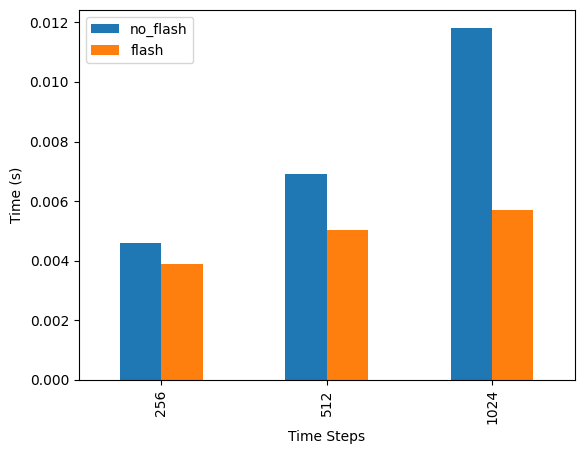

In [7]:
# T4 SRAM is smaller than newer GPUs, so less speedup gains
df["time"].plot.bar(xlabel="Time Steps", ylabel="Time (s)")

<Axes: xlabel='Time Steps', ylabel='Memory (GB)'>

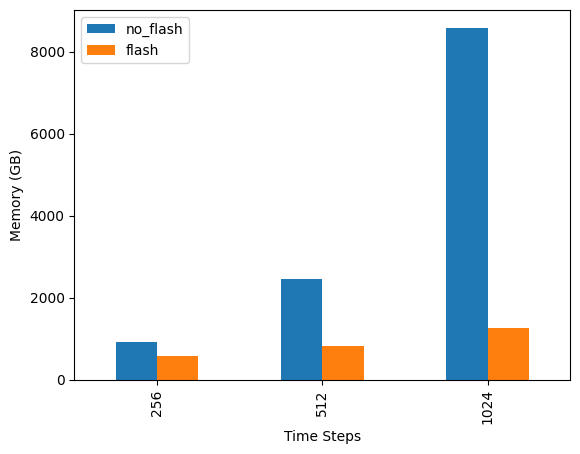

In [8]:
# Extrapolation gives you can fit 12.5K long sequence with batch size of 32 
# or a 400K long sequence with a batch size of 1 on this GPU
# But in practice, you're limited to a certain extent on the length of the 
# sequences that you can fit during training. This is a lot shorter as there's
# more computations (e.g. backward pass) during training and you need a larger
# batch size.
df["memory"].plot.bar(xlabel="Time Steps", ylabel="Memory (GB)")